Reading the Datasets

In [320]:
negative_examples = open('./data/neg_A0201.txt').read().split('\n')
positive_examples = open('./data/pos_A0201.txt').read().split('\n')

In [321]:
# extractive all letters which appear in the dataset
all_letters = [list(x) for x in negative_examples + positive_examples]
all_letters_flat = list(set([x for xs in all_letters for x in xs]))

# 2.a -> mapping each letter into an int from 0 to 8 
char_to_label = {k: idx for idx, k in enumerate(all_letters_flat)}

# reverse the mapping for easy use later
label_to_char = {v:k for k,v in char_to_label.items()}

In [322]:
def convert_text_to_record(acid_txt, label):
    return {
        'input': [char_to_label[c] for c in list(acid_txt)],
        'label': label
    }
# converting the datasets into 
negative_examples = [convert_text_to_record(r, 0) for r in negative_examples]
positive_examples = [convert_text_to_record(r, 1) for r in positive_examples]

In [323]:
import pandas as pd

all_examples = negative_examples + positive_examples
all_examples_df = pd.DataFrame(all_examples)
all_examples_df = all_examples_df.sample(frac=1.0)

In [324]:
from sklearn.model_selection import train_test_split

all_examples_df = all_examples_df[all_examples_df['input'].apply(lambda x: len(x) == 9)]
train, test = train_test_split(all_examples_df, test_size=0.1)

In [325]:
len(train[train['label'] == 1]) / len(train)

0.10895932724185332

In [326]:
import torch
import numpy as np

OVER_SAMPLING_RATION = 7

train = pd.concat([train[train['label'] == 0]] + [train[train['label'] == 1] for _ in range(OVER_SAMPLING_RATION)] ).sample(frac=1.0)

train_data = torch.Tensor([np.array(x) for x in train['input'].values])  # 100 samples, each with 'input_size' features
train_labels = torch.Tensor(train['label'].values).view(-1, 1)  # 100 binary labels

test_data = torch.Tensor(test['input'].to_list())
test_labels = torch.Tensor(test['label'].to_list()).view(-1, 1)

In [327]:
train['label'].describe()

count    40904.000000
mean         0.461202
std          0.498499
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [328]:
import random
import os

SEED = 42
g = torch.Generator()
g.manual_seed(SEED)
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.use_deterministic_algorithms(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(SEED)

In [336]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2):
        super(MLP, self).__init__()
        self.n_layers = n_layers
        self.hidden_layers = []
        self.relus = []
        for i in range(n_layers):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_size))
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
        for i in range(n_layers):
            self.relus.append(nn.ReLU())

    def forward(self, x):
        for i in range(self.n_layers):
            x = self.hidden_layers[i](x)
            x = self.relus[i](x)
        x = self.output_layer(x)
        return x
    
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [339]:
from sklearn.metrics import precision_score, recall_score

# Parameters
input_size = 9  # Example input size (number of features)
hidden_size = 128  # Number of neurons in the hidden layer
n_hidden_layers = 5
output_size = 1  # Binary output
learning_rate = 0.01
num_epochs = 250
batch_size = 128
print_interval = 1
    
train_dataset = CustomDataset(train_data, train_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generate dummy data (replace with your actual data)

# Initialize the model, loss function and optimizer
model = MLP(input_size, hidden_size, output_size, n_hidden_layers)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss with logits
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)  # StepLR scheduler

train_losses = []
test_losses = []
train_precisions = []
train_recalls = []
test_precisions = []
test_recalls = []

# Training loop
for epoch in range(num_epochs):
    for data, labels in train_loader:
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # outputs = model(train_data)
    # loss = criterion(outputs, train_labels)
    # 
    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
        model.eval()
        with torch.no_grad():
            # Training metrics
            train_outputs = model(train_data)
            train_loss = criterion(train_outputs, train_labels)
            train_predictions = (train_outputs >= 0.5).float()
            train_precision = precision_score(train_labels, train_predictions, zero_division=1)
            train_recall = recall_score(train_labels, train_predictions)
            train_losses.append(train_loss)
            train_precisions.append(train_precision)
            train_recalls.append(train_recall)
    
            # Test metrics
            test_outputs = model(test_data)
            test_loss = criterion(test_outputs, test_labels)
            test_predictions = (test_outputs >= 0.5).float()
            test_precision = precision_score(test_labels, test_predictions, zero_division=1)
            test_recall = recall_score(test_labels, test_predictions)
            test_losses.append(test_loss.item())
            test_precisions.append(test_precision)
            test_recalls.append(test_recall)
            print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Test Loss: {test_loss.item():.4f}')
        scheduler.step()

Epoch [1/250], Training Loss: 0.6881, Test Loss: 0.6665
Epoch [1/250], Training Loss: 0.6843, Test Loss: 0.6339
Epoch [1/250], Training Loss: 0.6821, Test Loss: 0.6088
Epoch [1/250], Training Loss: 0.6809, Test Loss: 0.5874
Epoch [1/250], Training Loss: 0.6800, Test Loss: 0.5756
Epoch [1/250], Training Loss: 0.6792, Test Loss: 0.5669
Epoch [1/250], Training Loss: 0.6784, Test Loss: 0.5597
Epoch [1/250], Training Loss: 0.6778, Test Loss: 0.5518
Epoch [1/250], Training Loss: 0.6769, Test Loss: 0.5472
Epoch [1/250], Training Loss: 0.6758, Test Loss: 0.5444
Epoch [1/250], Training Loss: 0.6747, Test Loss: 0.5420
Epoch [1/250], Training Loss: 0.6731, Test Loss: 0.5448
Epoch [1/250], Training Loss: 0.6713, Test Loss: 0.5489
Epoch [1/250], Training Loss: 0.6695, Test Loss: 0.5559
Epoch [1/250], Training Loss: 0.6678, Test Loss: 0.5633
Epoch [1/250], Training Loss: 0.6664, Test Loss: 0.5671
Epoch [1/250], Training Loss: 0.6650, Test Loss: 0.5720
Epoch [1/250], Training Loss: 0.6638, Test Loss:

KeyboardInterrupt: 

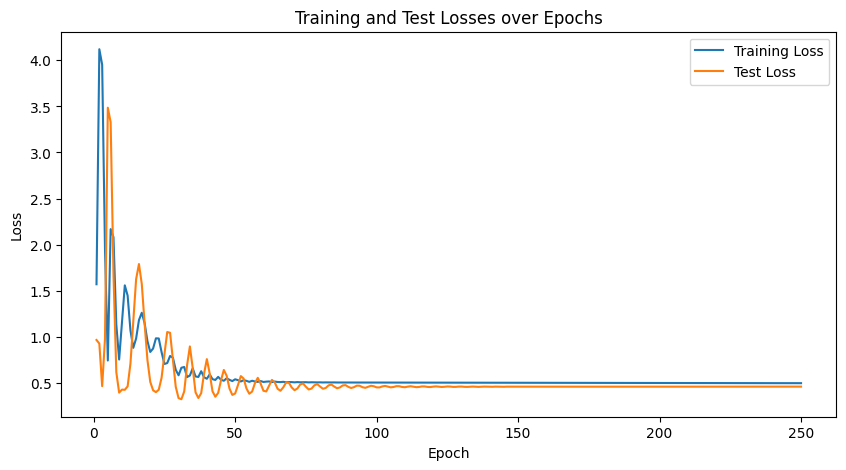

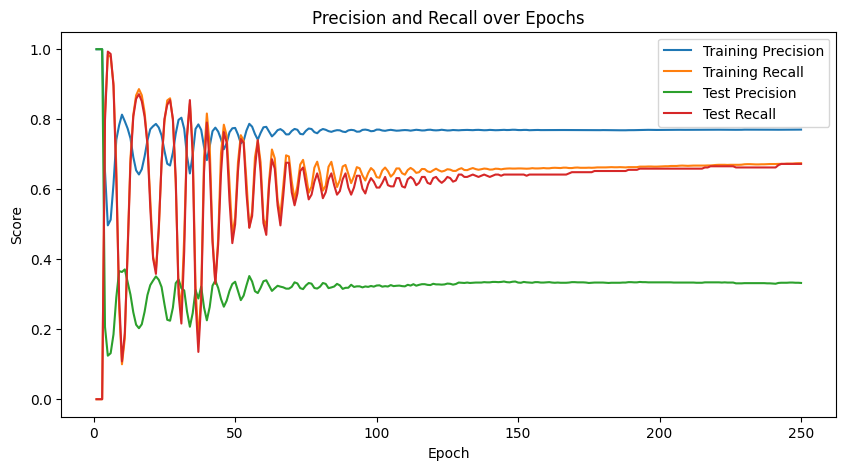

In [331]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(print_interval, num_epochs+1, print_interval), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses over Epochs')
plt.show()


# Plotting precision and recall
plt.figure(figsize=(10, 5))
plt.plot(range(print_interval, num_epochs+1, print_interval), train_precisions, label='Training Precision')
plt.plot(range(print_interval, num_epochs+1, print_interval), train_recalls, label='Training Recall')
plt.plot(range(print_interval, num_epochs+1, print_interval), test_precisions, label='Test Precision')
plt.plot(range(print_interval, num_epochs+1, print_interval), test_recalls, label='Test Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Precision and Recall over Epochs')
plt.show()

In [332]:
sars_cov_2_acids = open('./data/sara_acids', 'r').read()

all_sars_9_mer = [sars_cov_2_acids[n:n+9] for n in range(len(sars_cov_2_acids)-8)]

def get_pred(txt_input):
    sample_input = torch.Tensor([char_to_label[c] for c in list(txt_input)])
    predicted_output = model(sample_input)
    return torch.sigmoid(predicted_output).item()

all_sars_with_pred = [(a, get_pred(a), get_pred(a) > 0.5) for a in all_sars_9_mer]

In [333]:
sorted(all_sars_with_pred, key=lambda x: x[1], reverse=True)[:3]

[('CHDGKAHFP', 0.8824422359466553, True),
 ('VLNDILSRL', 0.8805953860282898, True),
 ('GLTVLPPLL', 0.8545286655426025, True)]